# Ice Drilling 

I'm using a very simple model where "ice drilling" just means transferring energy to the ice to melt it, which I'm sure misses some nuances.

In this model, there are either three or four independent variables:  power input, hole (drill) diameter, drill speed, and, depending on the design of the drill, depth (distance from surfac

In [2]:
import pandas as pd
import numpy as np

import math

%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# constants

Cp = 4.186            # specific heat of water in J / g K
Lf = 333.55           # enthalpy of fusion for water  J / g
water_density = 1e6   # g/m^3

# Drilling Model

Use very simplistic conservation of energy model where drilling through ice consists of melting a cylinder of ice of cross-sectional area $A$ and length $L$

$$ energy = L A \rho Lf$$

$ L = $ length of drillhole

$ A = $ area of hole

$\rho = $ density of ice $= 1e6 g/m^3$

$Lf = $ enthalpy of fusion of water  $= 333.55$ J/g

If you change both sides to a rate:

$$ power = V A \rho Lf$$

with $V = velocity$

In [4]:
## Convenience functions

def area( diam ):
    return math.pi * (diam/2.0)**2

## Ice Diver Analysis

In [5]:
diameters_cm = pd.Series([6,7,8,9,10,11,12,15,20,30])

ice_diver = pd.DataFrame(index=diameters_cm/100)
ice_diver.index.name = "diameter"

ice_diver['area'] = area(diam=ice_diver.index)

print(ice_diver)

              area
diameter          
0.06      0.002827
0.07      0.003848
0.08      0.005027
0.09      0.006362
0.10      0.007854
0.11      0.009503
0.12      0.011310
0.15      0.017671
0.20      0.031416
0.30      0.070686


In [15]:
icediver_generator = 1.6e3            # 1.6kW
icediver_electrical_efficiency = 0.75 # Efficiency of transmission from generator to probe (standin until we have a better model)

icediver_power_delivered = icediver_electrical_efficiency * icediver_generator
print("Ice diver electrical energy delivered: %.2f kW" % (icediver_power_delivered/1000))

icediver_diam = 0.07   # 7 cm
icediver_area = area(icediver_diam)
print("Ice diver cross section %.2e m^2" % icediver_area)

icediver_drill_speed = icediver_power_delivered / (icediver_area * water_density * Lf)  

print("Ice diver drill speed %.2e m/s (%.2f m/hour)" % (icediver_drill_speed, icediver_drill_speed*3600))


ice_diver['power_3m_hour'] = 3/3600 * ice_diver['area'] * water_density * Lf
ice_diver['power_5m_hour'] = 5/3600 * ice_diver['area'] * water_density * Lf
ice_diver['power_10m_hour'] = 10/3600 * ice_diver['area'] * water_density * Lf
ice_diver['power_30m_hour'] = 30/3600 * ice_diver['area'] * water_density * Lf


Ice diver electrical energy delivered: 1.20 kW
Ice diver cross section 3.85e-03 m^2
Ice diver drill speed 9.35e-04 m/s (3.37 m/hour)


## WISSARD

From:  

* Rack, Frank R., et al. "Developing a hot-water drill system for the WISSARD project: 1. Basic drill system components and design." Annals of Glaciology 55.68 (2014): 285-297.



In [13]:
# Thermal output from fuel input (from Rack 2014 pp 297)
num_heaters = 6
jp8_energy_density = 43e6   # Joules / kg
jp8_mass_density   = 0.809  # kg / L
heater_consumption = 0.0058 # L / s , manufacturer quoted
P_fuel = num_heaters * jp8_energy_density * jp8_mass_density * heater_consumption

fuel_to_water_eff = 0.75    # Thermal transfer efficency from burners to water
P_fuel_to_water = P_fuel * fuel_to_water_eff

print("WISSARD input power (from fuel consumption): %.2f kW" % (P_fuel/1000.0))
print("WISSARD output power (from fuel consumption): %.2f kW" % (P_fuel_to_water/1000))


# Alternate calculation from (Rack, 2014) using manufacturer-quoted temp rise for heaters
temp_rise = 52   # deg C
water_flow = 760  # ml/s/heater
P_water_temp_rise = num_heaters * temp_rise * water_flow * Cp

print("WISSARD output power (from heater-induced water temperature change): %.2f kW" % (P_water_temp_rise/1000))

# Third alternate calculation from Rack, 2014 actual change in temperature of water going into / coming out of hole.
# Water going into drill hole at approx 78C, comes out at near 0C.
# This is larger than the two above because it includes other waste heat generated in the camp, not just
# the output from the heaters.
water_temp_change = 78 
P_total_water_temp = num_heaters * water_flow * Cp * water_temp_change
print("WISSARD output power (from water temp change while in drillhole): %.2f kW" % (P_total_water_temp/1000))


wissard_hole_diam = 0.4   # 40cm
wissard_area = math.pi * (wissard_hole_diam/2)**2



WISSARD input power (from fuel consumption): 1210.59 kW
WISSARD output power (from fuel consumption): 907.94 kW
WISSARD output power (from heater-induced water temperature change): 992.58 kW
WISSARD output power (from water temp change while in drillhole): 1488.88 kW


In [8]:
wissard_drill_speed = P_fuel_to_water / (wissard_area * water_density * Lf)  

print("Predicted WISSARD drill speed: %.2f m/s (%.2f m/min, %.2f m/hour)" % (wissard_drill_speed, wissard_drill_speed*60, wissard_drill_speed*3600))

Predicted WISSARD drill speed: 0.02 m/s (1.30 m/min, 77.98 m/hour)


<IPython.core.display.Javascript object>


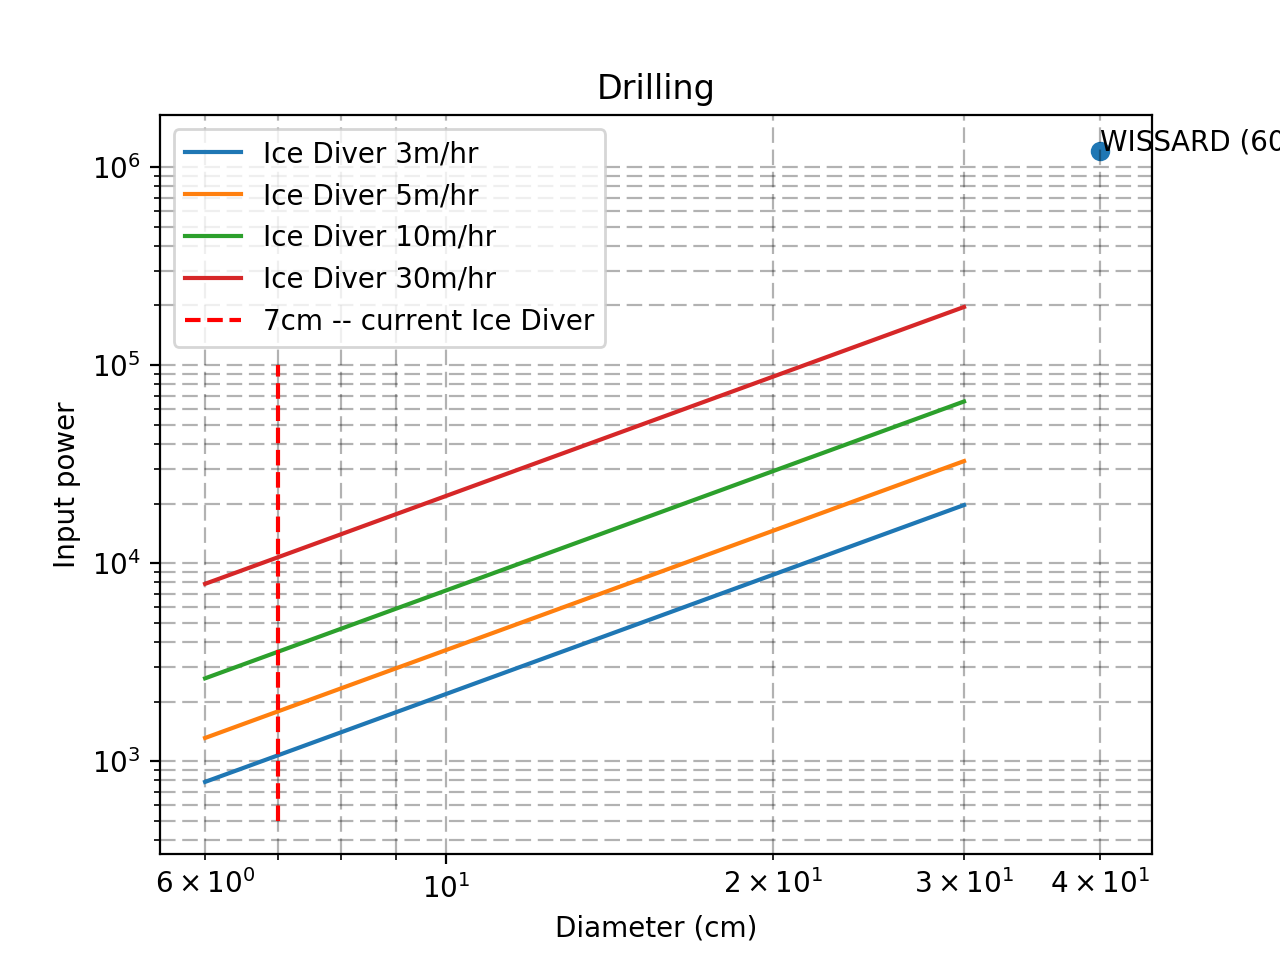

In [12]:
fig, ax = plt.subplots()

ax.set_title('Drilling')
ax.set_ylabel('Input power')
ax.set_xlabel('Diameter (cm)')
ax.loglog()

ax.scatter([0.4*100], [P_fuel])
ax.text(0.4*100, P_fuel, "WISSARD (60+ m/hr)")

ax.plot( ice_diver.index*100, ice_diver['power_3m_hour'], label='Ice Diver 3m/hr')
ax.plot( ice_diver.index*100, ice_diver['power_5m_hour'], label='Ice Diver 5m/hr')
ax.plot( ice_diver.index*100, ice_diver['power_10m_hour'], label='Ice Diver 10m/hr')
ax.plot( ice_diver.index*100, ice_diver['power_30m_hour'], label='Ice Diver 30m/hr')


ax.grid( color='k', alpha=0.3, linestyle='--', which='both')
ax.plot( [7,7], [500,10e4], 'r--', label='7cm -- current Ice Diver')
# ax.plot( [6,40], [1e4, 1e4], 'b--', label='10kW')

ax.legend()